Project: Titan Lightcurve - Brightness-phase curve

Author: Alex Medina

Organization: University of Central Florida

In [1]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Most important import, in order to read and manipulate image in .IMG or VICAR format
#The python package is called "rms-vicar"
import vicar
#The second most important package to use is called "opencv"
#Used to manipulate general images
#Not used in the brightness phase curves but to keep it consistent with the polarization phase curves
import cv2

Of course, in creating a brightness phase curve, we only need to calculate two things: brightness(or reflectivity) and phase. Phase is found by reading the metadata which will be involved later in a loop.

The calibrated images were formatted such that each pixel units of I/F. Most of the light off the limb of Titan is light scattered from Titan within the camera and you want to include it to get an accurate result. If you only want to get the integrated reflectivity for the entire image you just need to sum all of the pixels, including pixels not on Titan. If $\frac{I_j}{F}$ is the radiance from an image pixel $j$, then the irradiance from the whole Titan disk at the spacecraft-Titan distance $l$ is:

\begin{equation}
\mathcal{F} = \frac{\sum_{j} \frac{I_j}{F} \mathcal{S}_{\text{pixel}}}{l^2} .
\end{equation}

The above summation runs over all pixels $j$ within the circle of radius $R_{\text{target}}$, and $S_{\text{pixel}}$ is the projected area of a pixel at the distance. F depends on the spacecraft-Titan distance $l$, but unclear at the moment, hence, we introduce the following equation:

\begin{equation}
\mathcal{F} = \frac{\pi R_{\text{target}} \mathcal{A}_g \Phi(\alpha) }{l^2}
\end{equation}

This equation provides a definition of Titan’s overall reflectance, $A_g$ according to $R_{\text{target}}$ appropriate for Titan, and combining it with the original equation, we can derive the following expression:

\begin{equation}
\mathcal{A}_g \Phi(\alpha) = \frac{ \sum_{j} \frac{I_j}{F} \mathcal{S^2}_{\text{pixel}}} {\pi {R^2}_{\text{target}}}
\end{equation}

This is the equation we use for Titan's reflectivity (brightness), and given a Titan raidus of 2575 km, we continue.

In [11]:
def reflectivity(image, pixel_scale):
    #R is the radius of Titan for normalization
    R = 2575 #km

    #Total number of pixels
    n_pixel = np.pi * R**2 / pixel_scale**2
    total_IF = np.sum(image)

    return total_IF / n_pixel

Here, we input the path where the calibrated images are located. Of course, this is unique to my setup and the data that I have.

In [12]:
IF_images = r'C:\Users\Alex\Desktop\Titan\IF Images\CL1_BL2'

#Path to where the .csv file is from
IF_metadata = r'C:\Users\Alex\Desktop\Titan\IF Images\CL1_BL2\data.csv'

#Reading the .csv file
parameters_df = pd.read_csv(IF_metadata)

In the final computational step, there is a lot so I've integrated explanation within the algorithm itself.

In [13]:
images_refl   = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
#I use os.listdir(IF_images) to return a list of all file and directory names in where the IF images are located(as in I/F)
for filename in os.listdir(IF_images):
#The loop will interate over each filename that specifically ends with _CALIB.IMG because all other files(and there will be alot of other files like .lbl) are not relevant
    if filename.endswith('_CALIB.IMG'):
        #os.path.join(IF_images, filename) ensures the correct file path format
        #for example, if filename = N17_CALIB.IMG, then the image path IF_image_path = "C:\Users\Alex\Desktop\Titan\IF Images\CL1_BL2\N17_CALIB.IMG"
        IF_image_path = os.path.join(IF_images, filename)

        #Since these images are in .IMG(or .VIC) format, simple line to read image from rms-vicar package
        vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = vic.data_2d

        #Calibrated images are named as: N1463897371_1_CALIB.IMG
        #But the metadata is labled as: co-iss-n1463897371
        #The metadata associated with the calibrated image matches by n1463897371
        #Hence, the opus id comes from everything before the first underscore
        opus_id = filename.split('_')[0]

        #Adding the prefix 'co-iss-' to match the OPUS ID format in .csv, but also case sensitive
        #Hence we match the calibrated image with its metadata
        opus_id_with_prefix = f'co-iss-{opus_id}'.lower()

        #Associated row in the .csv
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id_with_prefix)]

        if not parameter_row.empty:
            #Assocating the meta data with the image, pixel_scale and phase_angle
            phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
            pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

            calc_refl = reflectivity(read_IF_image, pixel_scale)

            #Creating array to plot
            phase_angles.append(phase_angle)
            images_refl.append(calc_refl)

            #For manual inspection
            print(f'{filename}: {calc_refl}, {phase_angle}')

N1525327484_1_CALIB.IMG: 0.06221586085381125, 146.708
N1557905313_1_CALIB.IMG: 0.0986656001367244, 25.271
N1559282826_1_CALIB.IMG: 0.10457364780577175, 19.95
N1562037473_1_CALIB.IMG: 0.11132114163473002, 13.467
N1567440211_1_CALIB.IMG: 0.10560363144987397, 20.043
N1570185934_1_CALIB.IMG: 0.09810028080219844, 26.744
N1571476437_1_CALIB.IMG: 0.050156457949785224, 79.924
N1578503768_1_CALIB.IMG: 0.07293500366747209, 47.922
N1617163704_1_CALIB.IMG: 0.03735809841985432, 105.901
N1617165504_1_CALIB.IMG: 0.03723014271166407, 105.899
N1644998153_1_CALIB.IMG: 0.0959031064543076, 27.604
N1645008949_1_CALIB.IMG: 0.09301017396675618, 30.405
N1645019749_1_CALIB.IMG: 0.09034474939144974, 32.983
N1646535965_1_CALIB.IMG: 0.0833861324041618, 42.216
N1671761950_1_CALIB.IMG: 0.05341156388040707, 72.272
N1671884383_1_CALIB.IMG: 0.044458016217023846, 89.407
N1687626097_1_CALIB.IMG: 0.11176495038535635, 10.444
N1725076622_1_CALIB.IMG: 0.05503450653376233, 73.881
N1732144031_1_CALIB.IMG: 0.07148849500206218,

Now, we have all the important information, an image (or data point) with a reflectivity(y) and a phase angle(x).

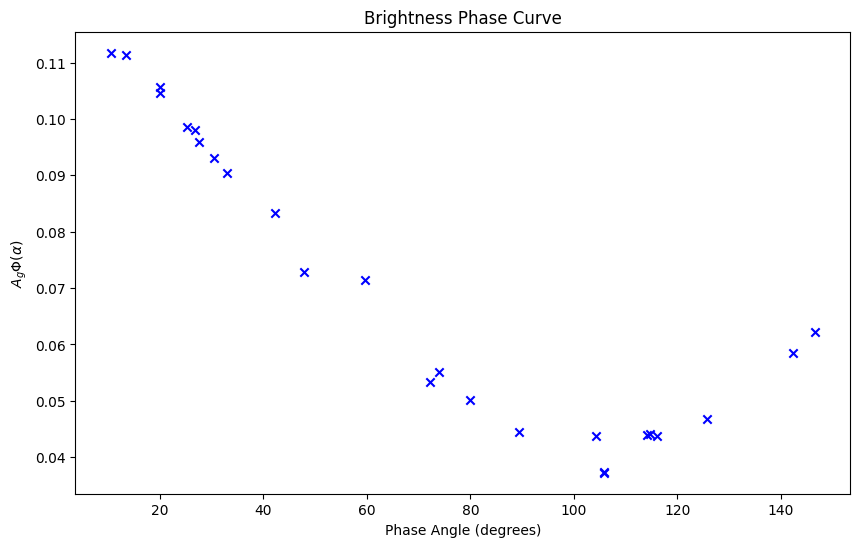

In [14]:
#Basic plot
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, images_refl, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')
plt.show()

Having examined outliers(explained in procedure), as a final step for consistency, I use the preliminary plot to gauge an idea for the maximum value. Some filters have a maximium value 5x higher than others and can be hard to identify meaningful physical parameters, hence, with this last section, I manually adjust the y axis height and tick number(at least divisible by 5). X-axis remains consistant across all filters.

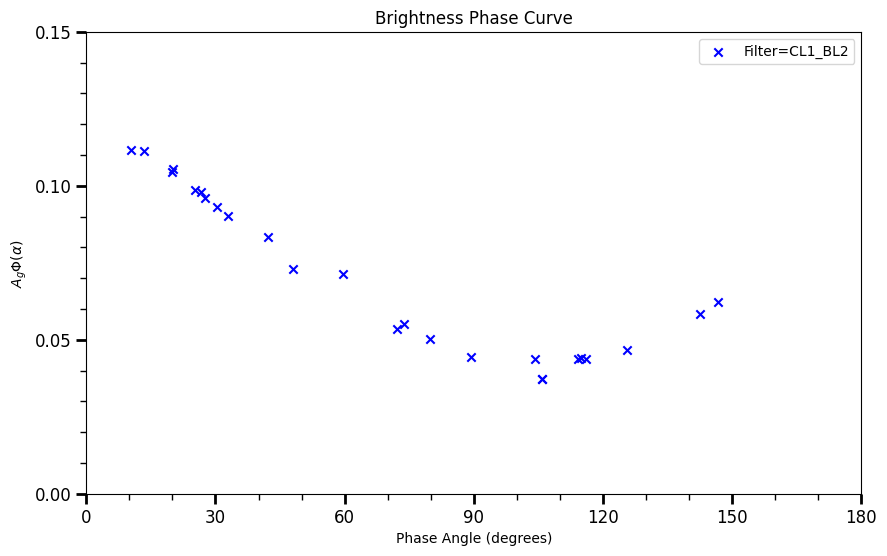

In [15]:
filtername = 'CL1_BL2'

#Same as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, images_refl, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.05 for i in range(4)], minor=False)
ay.set_yticks([i * 0.01 for i in range(15)], minor=True) 
plt.ylim(0, 0.15)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()